In [1]:
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.optim import AdamW

# Load pretrained CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



/home/sysadm/Music/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
# Load MIMIC-CXR dataset
train_dataset = load_dataset("itsanmolgupta/mimic-cxr-dataset", split="train[:90%]")  
val_datset = load_dataset("itsanmolgupta/mimic-cxr-dataset", split="train[:10%]")
train_dataset = train_dataset.filter(lambda x: x['impression'] is not None)
val_dataset = val_datset.filter(lambda x: x['impression'] is not None)

In [3]:
train_dataset

Dataset({
    features: ['image', 'findings', 'impression'],
    num_rows: 27561
})

In [4]:
val_dataset

Dataset({
    features: ['image', 'findings', 'impression'],
    num_rows: 3062
})

In [5]:
train_dataset[1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'findings': 'Lung volumes remain low. There are innumerable bilateral scattered small pulmonary nodules which are better demonstrated on recent CT. Mild pulmonary vascular congestion is stable. The cardiomediastinal silhouette and hilar contours are unchanged. Small pleural effusion in the right middle fissure is new. There is no new focal opacity to suggest pneumonia. There is no pneumothorax. ',
 'impression': 'Low lung volumes and mild pulmonary vascular congestion is unchanged. New small right fissural pleural effusion. No new focal opacities to suggest pneumonia.'}

In [6]:
# Preprocessing function
def preprocess(examples):
    images = [img.convert("RGB") for img in examples["image"]]
    texts = [text if text else "" for text in examples["impression"]]
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

# Custom PyTorch dataset wrapper
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = example["image"].convert("RGB")
        text = example["impression"]
        return {"image": image, "text": text}

# Collate function using CLIPProcessor
def collate_fn(batch):
    images = [b["image"] for b in batch]
    texts = [b["text"] for b in batch]
    return processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True)



In [7]:
# import torch
# from transformers import CLIPProcessor, CLIPModel
# from torch.utils.data import DataLoader
# import time
# from datetime import timedelta
# import numpy as np

# def do_train(model, train_dl, optimizer, lr_scheduler, device):
#     model.train()
#     total_loss = 0
#     total_batches = 0
#     start_time = time.time()
    
#     # Track metrics for reporting
#     running_loss = 0
#     log_interval = 100
    
#     for bid, batch in enumerate(train_dl):
#         batch_start = time.time()
        
#         # Move batch to device
#         batch = {k: v.to(device) for k, v in batch.items()}
        
#         # Forward pass
#         outputs = model(**batch, return_loss=True)
#         loss = outputs.loss
        
#         # Backward pass
#         loss.backward()
#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
        
#         # Accumulate loss (use float value to avoid GPU memory buildup)
#         batch_loss = loss.item()
#         total_loss += batch_loss
#         total_batches += 1
#         running_loss += batch_loss
        
#         # Logging
#         if bid % log_interval == 0:
#             if bid > 0:
#                 avg_running_loss = running_loss / log_interval
#                 running_loss = 0
#                 batch_time = time.time() - batch_start
#                 eta = batch_time * (len(train_dl) - bid)
                
#                 print(f"Batch {bid}/{len(train_dl)} | " 
#                       f"Loss: {avg_running_loss:.4f} | "
#                       f"LR: {lr_scheduler.get_last_lr()[0]:.6f} | "
#                       f"ETA: {str(timedelta(seconds=int(eta)))}")
#             else:
#                 print(f"Starting training on {len(train_dl)} batches...")
    
#     # Calculate average loss over all batches
#     avg_loss = total_loss / total_batches if total_batches > 0 else 0
#     total_time = time.time() - start_time
    
#     print(f"Training complete: {total_batches} batches in {str(timedelta(seconds=int(total_time)))}")
#     print(f"Average batch time: {total_time/total_batches:.2f}s | Average loss: {avg_loss:.4f}")
    
#     return avg_loss, total_time


# def do_eval(model, eval_dl, device):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total_examples = 0
#     start_time = time.time()
    
#     # Make sure we have data to validate on
#     if len(eval_dl) == 0:
#         print("Warning: Empty validation dataloader!")
#         return 0, 0, 0
    
#     print(f"Starting validation on {len(eval_dl)} batches...")
    
#     for bid, batch in enumerate(eval_dl):
#         # Move batch to device
#         batch = {k: v.to(device) for k, v in batch.items()}
        
#         # Forward pass without gradients
#         with torch.no_grad():
#             outputs = model(**batch, return_loss=True)
        
#         # Calculate loss and accumulate
#         loss = outputs.loss
#         total_loss += loss.item()
        
#         # Calculate accuracy: in CLIP, the diagonal elements should have the highest score
#         logits_per_image = outputs.logits_per_image
#         batch_size = logits_per_image.size(0)
        
#         if batch_size == 0:
#             print(f"Warning: Batch {bid} has size 0")
#             continue
            
#         # The expected labels in CLIP are the diagonal (matching text-image pairs)
#         labels = torch.arange(batch_size).to(device)
#         predictions = torch.argmax(logits_per_image, dim=1)
        
#         # Count correct predictions
#         batch_correct = (predictions == labels).sum().item()
#         correct += batch_correct
#         total_examples += batch_size
        
#         # Log progress
#         if (bid + 1) % 10 == 0 or (bid + 1) == len(eval_dl):
#             print(f"Validated {bid+1}/{len(eval_dl)} batches | "
#                   f"Current Accuracy: {100 * correct / total_examples:.2f}%")
    
#     # Calculate averages
#     avg_loss = total_loss / len(eval_dl) if len(eval_dl) > 0 else 0
#     accuracy = correct / total_examples if total_examples > 0 else 0
#     total_time = time.time() - start_time
    
#     print(f"Validation complete: {total_examples} examples in {str(timedelta(seconds=int(total_time)))}")
#     print(f"Validation Loss: {avg_loss:.4f} | Accuracy: {100 * accuracy:.2f}%")
    
#     return avg_loss, accuracy, total_time

In [8]:
import torch
import time
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

def do_train(model, train_loader, optimizer, epoch, device):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch, return_loss=True)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    train_time = time.time() - start_time
    avg_train_loss = total_loss / len(train_loader)

    print(f"✅ Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Time: {train_time:.2f}s")
    return avg_train_loss, train_time


@torch.no_grad()
def do_eval(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    start_time = time.time()

    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch, return_loss=True)
        loss = outputs.loss
        total_loss += loss.item()

        # Cosine similarity for prediction
        image_embeds = model.get_image_features(pixel_values=batch['pixel_values'])
        text_embeds = model.get_text_features(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Normalize
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        logits = (image_embeds @ text_embeds.T)  # [B, B]
        preds = torch.argmax(logits, dim=1)
        labels = torch.arange(len(preds)).to(device)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    val_time = time.time() - start_time
    avg_val_loss = total_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)

    print(f"📊 Validation Loss: {avg_val_loss:.4f} - Val_Accuracy: {val_acc*100:.2f}% - Time: {val_time:.2f}s")
    return avg_val_loss, val_acc, val_time


In [ ]:
# CLAUDE SUGGESTION:

import torch
import time
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch.nn.utils import clip_grad_norm_

def do_train(model, train_loader, optimizer, epoch, device, scheduler=None, max_grad_norm=1.0):
    model.train()
    total_loss = 0.0
    start_time = time.time()
    
    for batch_idx, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch, return_loss=True)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        if max_grad_norm > 0:
            clip_grad_norm_(model.parameters(), max_grad_norm)
            
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        
        # Report progress for long epochs
        if batch_idx % 50 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
    # Step the scheduler if provided
    if scheduler is not None:
        scheduler.step()
    
    train_time = time.time() - start_time
    avg_train_loss = total_loss / len(train_loader)
    
    return avg_train_loss, train_time

@torch.no_grad()
def do_eval(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    start_time = time.time()
    
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Get loss
        outputs = model(**batch, return_loss=True)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Get image and text features
        image_embeds = model.get_image_features(pixel_values=batch['pixel_values'])
        text_embeds = model.get_text_features(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask']
        )
        
        # Normalize
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        
        # Compute similarity
        logits = torch.matmul(image_embeds, text_embeds.T) * model.logit_scale.exp()
        
        # Prediction (diagonal elements should be highest)
        preds = torch.argmax(logits, dim=1)
        labels = torch.arange(len(preds)).to(device)
        
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
    
    val_time = time.time() - start_time
    avg_val_loss = total_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    
    return avg_val_loss, val_acc, val_time

In [9]:
# DataLoader
train_ds = CLIPDataset(train_dataset)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
# Validation DataLoader
val_dataset = CLIPDataset(val_dataset)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-6)

In [ ]:
train_losses, val_losses, val_accuracies = [], [], []
EPOCHS=3
for epoch in range(EPOCHS):
    print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")

    avg_train_loss, train_time = do_train(model, train_loader, optimizer, epoch, device="cuda")
    avg_val_loss, val_acc, val_time = do_eval(model, val_loader, device="cuda")
    print(f"\n🚀Epoch {epoch+1} Summary:")
    print(f"✅ Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Time: {train_time:.2f}s")
    print(f"📊 Validation Loss: {avg_val_loss:.4f} - Val_Accuracy: {val_acc*100:.2f}% - Time: {val_time:.2f}s")


    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)


✅ Epoch 1 - Train Loss: 2.2075 - Time: 314.76s
📊 Validation Loss: 1.8869 - Val_Accuracy: 34.91% - Time: 28.46s
✅ Epoch 2 - Train Loss: 1.6760 - Time: 335.75s
📊 Validation Loss: 1.4811 - Val_Accuracy: 46.24% - Time: 27.15s
✅ Epoch 3 - Train Loss: 1.3008 - Time: 337.86s
📊 Validation Loss: 1.1523 - Val_Accuracy: 58.16% - Time: 27.94s


In [11]:




# # Training loop
# model.train()
# for epoch in range(3):
#     for batch in train_loader:
#         batch = {k: v.cuda() for k, v in batch.items()}
#         outputs = model(**batch, return_loss=True)
#         loss = outputs.loss

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#     print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")
# EPOCHS = 10
# # Learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# # Move model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# # Training and evaluation loop
# print("Starting training and evaluation loop...")
# print(f"Using device: {device}")
# for epoch in range(EPOCHS):
#     print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")
#     train_loss, train_time = do_train(model, train_loader, optimizer, lr_scheduler, device)
#     # val_loss, val_acc, val_time = do_eval(model, val_loader, device)

#     print("\n=================================================================================")
#     print(f"Epoch {epoch+1} Summary:")
#     print(f"  Train Loss: {train_loss:.4f} | Train Time: {str(timedelta(seconds=int(train_time)))}")
#     # print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Time: {str(timedelta(seconds=int(val_time)))}") 

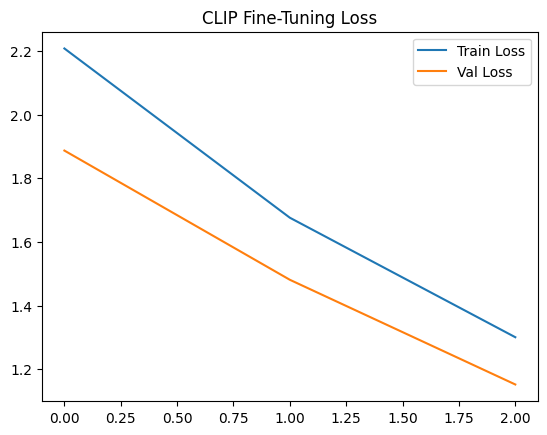

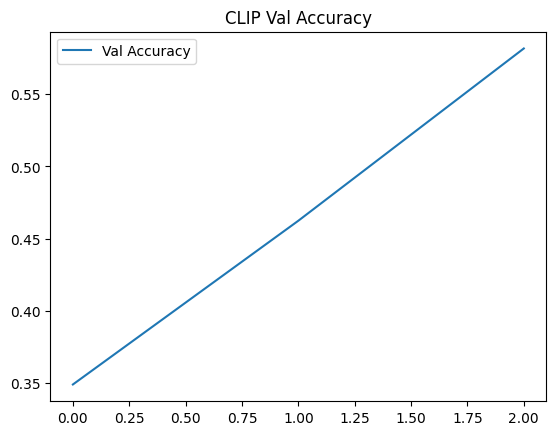

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("CLIP Fine-Tuning Loss")
plt.legend()
plt.show()

plt.plot(val_accuracies, label="Val Accuracy")
plt.title("CLIP Val Accuracy")
plt.legend()
plt.show()
